# Инструменты для работы с языком

... или зачем нужна предобработка.

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Классификацию по тональности используют в рекомендательных системах, чтобы понять, понравилось ли людям кафе, кино, etc.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [1]:
# если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2025-12-07 08:24:44--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/6mg7rw3wltux83q2o4ah4/positive.csv?rlkey=cvruhzofza9kkfxwzyp2vskfd [following]
--2025-12-07 08:24:45--  https://www.dropbox.com/scl/fi/6mg7rw3wltux83q2o4ah4/positive.csv?rlkey=cvruhzofza9kkfxwzyp2vskfd
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd01bdd7c1a6232d43ed94df076.dl.dropboxusercontent.com/cd/0/inline/C2kB_Cv_CIwPO7tqSvsVahtrG6R8vVSzKPd1_k4MNf9fiieGweec-PwPqEBwFcJ23nTnFIOedKT8PJtBJnwzoaNmah5MhpO75YWYDMTU96pnAKWM1txhwJ7CV5HWgpDyDAk/file# [following]
--2025-12-07 08:24:45--  https://ucd01bdd7c1a6232d43ed94df076.dl.dropboxusercontent.com/cd/0/inline/C2kB_Cv_CIwPO7tqSvsVah

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = pd.concat([positive, negative])

In [4]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226834 entries, 0 to 111922
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    226834 non-null  object
 1   label   226834 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


In [6]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [7]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [8]:
from nltk import ngrams

In [9]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [10]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [11]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [12]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [13]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [14]:
list(vec.vocabulary_.items())[:10]

[('хватит', 232961),
 ('мне', 158917),
 ('писать', 182381),
 ('не', 165182),
 ('хочу', 234296),
 ('тобой', 222023),
 ('общаться', 171379),
 ('happyeggs_', 36312),
 ('тольятти', 222338),
 ('сс', 215608)]

In [15]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [16]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.77      0.75      0.76     28207
    positive       0.76      0.77      0.77     28502

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



In [17]:
clf

LogisticRegression(random_state=42)

In [18]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [19]:
[v for v in dir(clf) if '__' not in v]

['C',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 '_validate_params',
 'class_weight',
 'classes_',
 'coef_',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'get_metadata_routing',
 'get_params',
 'intercept_',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_features_in_',
 'n_iter_',
 'n_jobs',
 'penalty',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'score',
 'set_fit_request',
 'set_params',
 'set_score_request',
 'solver',
 'sparsify',
 'tol',
 'verbose',
 'warm_start']

Попробуем сделать то же самое для триграмм:

In [20]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.47      0.71      0.57     18322
    positive       0.82      0.62      0.70     38387

    accuracy                           0.65     56709
   macro avg       0.64      0.66      0.63     56709
weighted avg       0.71      0.65      0.66     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_{t}}{\sum_k n_{k}} $$

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом
количестве документов, у него высокий TF-IDF.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.73      0.76      0.75     26744
    positive       0.78      0.75      0.77     29965

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## Токенизация

Токенизировать -- значит, поделить текст на слова, или *токены*.

Самый наивный способ токенизировать текст -- разделить с помощью `split`. Но `split` упускает очень много всего, например, банально не отделяет пунктуацию от слов. Кроме этого, есть ещё много менее тривиальных проблем. Поэтому лучше использовать готовые токенизаторы.

In [23]:
from nltk.tokenize import word_tokenize

In [24]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [25]:
example = 'Но не каждый хочет что-то исправлять:('
word_tokenize(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']

В nltk вообще есть довольно много токенизаторов:

In [26]:
from nltk import tokenize
dir(tokenize)[:16]

['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'PunktTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'SyllableTokenizer',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer']

Они умеют выдавать индексы начала и конца каждого токена:

In [27]:
wh_tok = tokenize.WhitespaceTokenizer()
list(wh_tok.span_tokenize(example))

[(0, 2), (3, 5), (6, 12), (13, 18), (19, 25), (26, 38)]

(если вам было интересно, зачем вообще включать в модуль токенизатор, который работает как `.split()` :))

Некторые токенизаторы ведут себя специфично:

In [28]:
tokenize.TreebankWordTokenizer().tokenize("don't stop me")

['do', "n't", 'stop', 'me']

Для некоторых задач это может быть полезно.

А некоторые -- вообще не для текста на естественном языке (не очень понятно, зачем это в nltk :)):

In [29]:
tokenize.SExprTokenizer().tokenize("(a (b c)) d e (f)")

['(a (b c))', 'd', 'e', '(f)']

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [32]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [33]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [34]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, token_pattern=None, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.80      0.76      0.78     29181
    positive       0.76      0.80      0.78     27528

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [35]:
!pip install pymystem3

In [36]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [37]:
print(mystem_analyzer.lemmatize(example))

['но', ' ', 'не', ' ', 'каждый', ' ', 'хотеть', ' ', 'что-то', ' ', 'исправлять', ':(\n']


А можно получить грамматическую информацию:

In [38]:
mystem_analyzer.analyze(example)

[{'analysis': [{'lex': 'но', 'wt': 0.9998906299, 'gr': 'CONJ='}],
  'text': 'Но'},
 {'text': ' '},
 {'analysis': [{'lex': 'не', 'wt': 1, 'gr': 'PART='}], 'text': 'не'},
 {'text': ' '},
 {'analysis': [{'lex': 'каждый',
    'wt': 0.9985975799,
    'gr': 'APRO=(вин,ед,муж,неод|им,ед,муж)'}],
  'text': 'каждый'},
 {'text': ' '},
 {'analysis': [{'lex': 'хотеть',
    'wt': 1,
    'gr': 'V,несов,пе=непрош,ед,изъяв,3-л'}],
  'text': 'хочет'},
 {'text': ' '},
 {'analysis': [{'lex': 'что-то', 'wt': 1, 'gr': 'SPRO,ед,сред,неод=(вин|им)'}],
  'text': 'что-то'},
 {'text': ' '},
 {'analysis': [{'lex': 'исправлять', 'wt': 1, 'gr': 'V,пе=инф,несов'}],
  'text': 'исправлять'},
 {'text': ':(\n'}]

Давайте терепь лемматизатор майстема в качестве токенизатора.

In [39]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [40]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc, token_pattern=None)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.77      0.74      0.75     28741
    positive       0.74      0.77      0.75     27968

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709



### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [41]:
!pip install pymorphy3 pymorphy3-dicts-ru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 88.6 MB/s eta 0:00:00


In [42]:
from pymorphy3 import MorphAnalyzer
pymorphy3_analyzer = MorphAnalyzer()

pymorphy3 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [43]:
ana = pymorphy3_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2471, 10),))]

In [44]:
ana[0].normal_form

'платить'

А теперь напишите аналогичную функцию для лемматизации с pymorphy2:

In [45]:
example

'Но не каждый хочет что-то исправлять:('

In [46]:
import re
def my_preproc_pyMorph_3(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text_mas = []
    for word in text.split(' '):
      word_t = pymorphy3_analyzer.parse(word)
      text_mas.append(word_t[0].normal_form)
    return [word for word in text_mas if word not in stopwords.words('russian') + [' ', '\n']]

In [47]:
my_preproc_pyMorph_3(example)

['каждый', 'хотеть', 'чтоть', 'исправлять']

Что будет, если использовать её в качестве препроцессора?

In [48]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc_pyMorph_3, token_pattern=None)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.76      0.73      0.74     28985
    positive       0.73      0.76      0.74     27724

    accuracy                           0.74     56709
   macro avg       0.74      0.74      0.74     56709
weighted avg       0.75      0.74      0.74     56709



### mystem vs. pymorphy

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту:

In [49]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292664, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970041, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [50]:
from collections import Counter

In [51]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [52]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

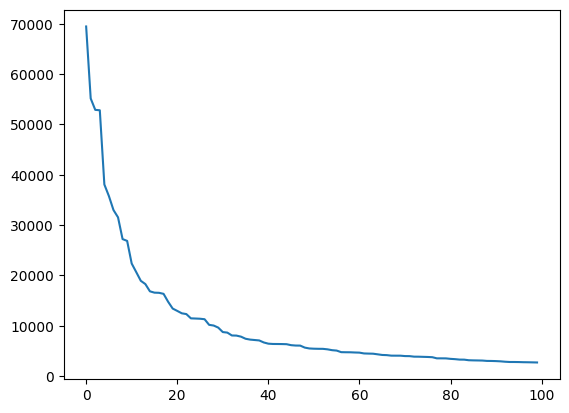

In [53]:
import matplotlib.pyplot as plt

first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [54]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, token_pattern=None)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27751
    positive       1.00      1.00      1.00     28958

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

In [55]:
bow[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12 stored elements and shape (1, 259880)>

In [58]:
df = pd.DataFrame(bow[0].T.todense(),
  index=vec.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
# print(df[df['TF-IDF']])

In [59]:
range(bow.shape[0])[:100]

range(0, 100)

In [60]:
df = pd.DataFrame(bow[0].T.todense(),
  index=vec.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
df = df[df['TF-IDF'] > 0]


In [61]:
df

,TF-IDF
общаться,0.489252
хватит,0.451270
писать,0.397615
тобой,0.385214
хочу,0.276885
мне,0.218347
с,0.191493
.,0.163662
я,0.146739
не,0.138865


In [65]:
# df.loc['бабулька'].unique()[0]

In [63]:
dict_ = {}
count = 0
for i in range(bow.shape[0])[:1000]:
  count += 1
  if count % 10 == 0:
    print(count, " / ",1000)
  df = pd.DataFrame(bow[i].T.todense(),
  index=vec.get_feature_names_out(), columns=["TF-IDF"])
  df = df.sort_values('TF-IDF', ascending=False)
  df = df[df['TF-IDF'] > 0]

  for ind in df.index:
    if ind in dict_:
      dict_[ind] += df.loc[ind].unique()[0]
    else:
      dict_[ind] = df.loc[ind].unique()[0]


10  /  1000
20  /  1000
30  /  1000
40  /  1000
50  /  1000
60  /  1000
70  /  1000
80  /  1000
90  /  1000
100  /  1000
110  /  1000
120  /  1000
130  /  1000
140  /  1000
150  /  1000
160  /  1000
170  /  1000
180  /  1000
190  /  1000
200  /  1000
210  /  1000
220  /  1000
230  /  1000
240  /  1000
250  /  1000
260  /  1000
270  /  1000
280  /  1000
290  /  1000
300  /  1000
310  /  1000
320  /  1000
330  /  1000
340  /  1000
350  /  1000
360  /  1000
370  /  1000
380  /  1000
390  /  1000
400  /  1000
410  /  1000
420  /  1000
430  /  1000
440  /  1000
450  /  1000
460  /  1000
470  /  1000
480  /  1000
490  /  1000
500  /  1000
510  /  1000
520  /  1000
530  /  1000
540  /  1000
550  /  1000
560  /  1000
570  /  1000
580  /  1000
590  /  1000
600  /  1000
610  /  1000
620  /  1000
630  /  1000
640  /  1000
650  /  1000
660  /  1000
670  /  1000
680  /  1000
690  /  1000
700  /  1000
710  /  1000
720  /  1000
730  /  1000
740  /  1000
750  /  1000
760  /  1000
770  /  1000
780  /  

In [66]:
dict_

{'общаться': np.float64(0.489252176539351),
 'хватит': np.float64(0.9510003710840043),
 'писать': np.float64(2.6190907382105477),
 'тобой': np.float64(2.2595419102739385),
 'хочу': np.float64(6.937827315944727),
 'мне': np.float64(12.921099082187245),
 'с': np.float64(15.38067682416825),
 '.': np.float64(23.970565040144358),
 'я': np.float64(25.145117314125145),
 'не': np.float64(29.772668750626313),
 '(': np.float64(58.799059269264156),
 ',': np.float64(48.14885807615652),
 'happyeggs_': np.float64(0.4341006263541851),
 'приоры': np.float64(0.42364639156042305),
 'лады': np.float64(0.40331021005452256),
 'тольятти': np.float64(0.3710660182119829),
 'сс': np.float64(0.7013713488354847),
 'делают': np.float64(0.29242728792263556),
 'х': np.float64(1.200244477027665),
 'нас': np.float64(2.648076753905694),
 ')': np.float64(52.86659499051009),
 'у': np.float64(12.843655548220998),
 '@': np.float64(40.464089681549254),
 ':': np.float64(45.42350903891422),
 'olenipie': np.float64(0.37026492

In [67]:
freq_dict_sorted= sorted(dict_.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('(', np.float64(58.799059269264156)),
 (')', np.float64(52.86659499051009)),
 (',', np.float64(48.14885807615652)),
 (':', np.float64(45.42350903891422)),
 ('@', np.float64(40.464089681549254)),
 ('не', np.float64(29.772668750626313)),
 ('я', np.float64(25.145117314125145)),
 ('.', np.float64(23.970565040144358)),
 ('!', np.float64(22.95636984298234)),
 ('и', np.float64(21.817479149225246))]

In [68]:
print(df[df['TF-IDF'] > 0])

                 TF-IDF
корректировка  0.343627
изначальное    0.343627
a_w_sleep      0.332347
домодедово     0.305058
полета         0.293778
путаю          0.285774
вобще          0.249944
статус         0.233432
ща             0.214147
времени        0.180492
прям           0.178180
раньше         0.178180
время          0.151779
был            0.151263
может          0.149967
.              0.147535
только         0.117416
но             0.101998
с              0.086312
и              0.068350
)              0.052031
@              0.047040
,              0.045303


In [70]:
# x_train[0].unique()

In [71]:
features_vec = vec.get_feature_names_out()

In [72]:
x_train[1]

,text
1,"Коллеги сидят рубятся в Urban terror, а я из-з..."
1,"Да, все-таки он немного похож на него. Но мой ..."


In [73]:
y_train[1]

,label
1,negative
1,positive


In [74]:
# vec.transform([x_train[1]])

AttributeError: 'Series' object has no attribute 'lower'

In [ ]:
# x_train_1_transform = vec.transform([x_train[1]])

In [ ]:
# max(x_train_1_transform)

In [ ]:
# for val in x_train_1_transform[0]:
  print(val)
  break

In [75]:
features_vec[217266]

'рубцовского.пиздец'

In [76]:
features_vec[96]

'+перелет'

In [78]:
# x_train_1

In [79]:
s = " ".join(list(x_train))


In [80]:
s[:100]

'Хватит мне писать, я не хочу с тобой общаться.( @happyeggs_ с Тольятти сс: У нас лады приоры делают '

In [81]:
corpus = [token for tweet in x_train for token in word_tokenize(tweet)]
print(len(corpus))
corpus[:10]

3018067


['Хватит', 'мне', 'писать', ',', 'я', 'не', 'хочу', 'с', 'тобой', 'общаться']

In [82]:
freq_dict = Counter(s)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[(' ', 2070962),
 ('о', 901626),
 ('а', 784418),
 ('е', 728202),
 ('т', 576707),
 ('н', 543947),
 ('и', 504647),
 ('с', 414963),
 ('л', 349380),
 ('р', 339664)]

In [83]:
bow.shape

(170125, 259880)

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [86]:
# cool_token =
# pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
# print(classification_report(pred, y_test))

## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [87]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.99      1.00      0.99     27685
    positive       1.00      0.99      1.00     29024

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

## Регулярки

(если осталось время)

Вообще, часто бывает так, что для конкретного случая нужен особый способ токенизации, и надо самостоятельно написать регулярку. Или, например, перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее.

Навык полезный, давайте в нём тоже потренируемся.

In [88]:
import re

### findall
возвращает список всех найденных совпадений

In [90]:
result = re.findall('ab+c.', 'abcdefghijkabcabcxabc')
print(result)

['abcd', 'abca']


Вопрос на внимательность: почему нет abcx?

**Задание**: вернуть список первых двух букв каждого слова в строке, состоящей из нескольких слов.

In [91]:
textString = "dsnj jjjd oodj()das asd 8 -3"

In [92]:
regExprFirst2 = r'(?>=\S|\b)\S\S?'

In [93]:
result = re.findall(regExprFirst2, textString)
print(result)

['ds', 'jj', 'oo', '()', 'da', 'as', '8', '3']


In [94]:
result = re.findall(regExprFirst2, 'itsy, bitsy, teenie, weenie')
print(result)

['it', ',', 'bi', ',', 'te', ',', 'we']


### split
разделяет строку по заданному шаблону


In [95]:
result = re.split(',', 'itsy, bitsy, teenie, weenie')
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


можно указать максимальное количество разбиений

In [96]:
result = re.split(',', 'itsy, bitsy, teenie, weenie', maxsplit = 2)
print(result)

['itsy', ' bitsy', ' teenie, weenie']


**Задание**: разбейте строку, состоящую из нескольких предложений, по точкам, но не более чем на 3 предложения.

In [97]:
result = re.split(r'\.+|!+|\?+', 'itsy, bitsy! teenie?dasdd asdo878. weenie... yury', maxsplit = 4)
print(result)

['itsy, bitsy', ' teenie', 'dasdd asdo878', ' weenie', ' yury']


### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [98]:
result = re.sub('a', 'b', 'abcabc')
print (result)

bbcbbc


**Задание**: напишите регулярку, которая заменяет все цифры в строке на "DIG".

In [99]:
result = re.sub(r'\d', 'DIG', 'poommfp43587fgbhi3g')
print (result)

poommfpDIGDIGDIGDIGDIGfgbhiDIGg


**Задание**: напишите регулярку, которая убирает url из строки.

In [104]:
result = re.sub(r'https?://.+\s', ' ', 'jnuhbhttp://dsfd.fd.com erdkg')
print (result)

jnuhb erdkg


### compile
компилирует регулярное выражение в отдельный объект

In [101]:
# Пример: построение списка всех слов строки:
prog = re.compile(r'[А-Яа-яё\-]+')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'Да', 'больше', 'ещё', 'больше', 'слов', 'Что-то', 'ещё']

**Задание**: для выбранной строки постройте список слов, которые длиннее трех символов.

In [102]:
# Пример: построение списка всех слов строки:
prog = re.compile(r'\b\w{4,}')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'больше', 'больше', 'слов']

**Задание**: вернуть список доменов (@gmail.com) из списка адресов электронной почты:

```
abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz
```

In [103]:
adresses = 'abc.test@gmail.com, abc.test@gmail.com.km, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz'

prog = re.compile(r'@\w+[\.\w+]+\b')
prog.findall(adresses)

['@gmail.com',
 '@gmail.com.km',
 '@test.in',
 '@analyticsvidhya.com',
 '@rest.biz']

Если всё ещё осталось время: [регулярочный кроссворд ¯\_(ツ)_/¯](https://mariolurig.com/crossword/)